In [1]:
import MetaTrader5 as mt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from datetime import datetime, time

In [2]:
mt.initialize()


True

In [3]:
login = #add your login
password = #add your pass in string
server = #add server name in string
mt.login(login, password, server)

True

In [12]:
rates = mt.copy_rates_from("US30", mt.TIMEFRAME_M1, datetime.now(), 99999)   #fn to copy rates/data from mt5 in array format
data = pd.DataFrame(rates) #converting it to dataframe coz I like it
data['time'] = pd.to_datetime(data['time'], unit='s') 
data.set_index('time', inplace = True)
data.drop(columns=['real_volume'], inplace = True)
data.drop(columns=['spread'], inplace = True)

In [13]:
data

,open,high,low,close,tick_volume
time,,,,,
2023-11-14 08:23:00,34323.70,34324.70,34322.71,34322.71,18
2023-11-14 08:24:00,34323.21,34324.20,34322.71,34323.71,30
2023-11-14 08:25:00,34323.21,34325.20,34322.71,34325.20,16
2023-11-14 08:26:00,34324.71,34326.20,34324.71,34324.71,20
2023-11-14 08:27:00,34325.21,34326.20,34323.72,34324.71,11
...,...,...,...,...,...
2024-02-27 16:52:00,38944.59,38963.99,38943.57,38959.55,424
2024-02-27 16:53:00,38960.05,38967.83,38956.05,38962.70,294
2024-02-27 16:54:00,38963.20,38965.15,38949.09,38959.37,309


In [16]:
time_intervals_to_train = 30   #I will take 30 previous candles data as input for predicting the next candle
prediction_intervals = 1   #The next candle to be predicted

X = []
y = []

In [17]:
for i in range(time_intervals_to_train, len(data) - prediction_intervals):
    X.append(data.iloc[i - time_intervals_to_train: i, 0:5])       #appending the prev 30 candles data in X
    y.append(data.iloc[i + prediction_intervals, 1:3])            #appending the candles from 31st candle in y
    
    
    #we are taking OHLC and tick vol columns for training input and High Low columns for outputs.
X = np.array(X)
y = np.array(y)

In [18]:
samples, sequence_length, features = X.shape
X_2d = np.reshape(X, (samples * sequence_length, features))          #cannot scale a 3d array so first storing its dimensions
                                                                       #and converting it into 2d

In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X_2d)
y = scaler.fit_transform(y)

In [20]:
X = np.reshape(X, (samples, sequence_length, features))     #reshaping into 3d

In [21]:
test_size = int(len(X) * 0.2)
X_test = X[-test_size:]
X_train = X[:-test_size]
y_test = y[-test_size:]
y_train = y[:-test_size]
validation_size = int(len(X_train) * 0.2)
X_val = X_train[-validation_size:]
y_val = y_train[-validation_size:]
X_train = X_train[:-validation_size]
y_train = y_train[:-validation_size]                      #splitting into train test and validation

In [22]:
model = Sequential()
model.add(LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=64, activation='relu'))                          #this setting gave me the best model result
model.add(Dense(units=y_train.shape[1], activation='linear'))

In [23]:

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


In [25]:
model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_val, y_val)) 
#I stopped the training midway bcoz I though the accuracy was high enough

Epoch 1/15
2000/2000 [==============================] - 33s 15ms/step - loss: 4.5257e-04 - accuracy: 0.6283 - val_loss: 5.6818e-05 - val_accuracy: 0.7791
Epoch 2/15
2000/2000 [==============================] - 30s 15ms/step - loss: 1.0911e-05 - accuracy: 0.5850 - val_loss: 4.6524e-05 - val_accuracy: 0.7791
Epoch 3/15
2000/2000 [==============================] - 30s 15ms/step - loss: 9.9411e-06 - accuracy: 0.6194 - val_loss: 1.1145e-04 - val_accuracy: 0.7799
Epoch 4/15
2000/2000 [==============================] - 30s 15ms/step - loss: 9.6284e-06 - accuracy: 0.6473 - val_loss: 2.9773e-05 - val_accuracy: 0.7955
Epoch 5/15
2000/2000 [==============================] - 30s 15ms/step - loss: 7.1179e-06 - accuracy: 0.6593 - val_loss: 6.2956e-06 - val_accuracy: 0.8582
Epoch 6/15
2000/2000 [==============================] - 32s 16ms/step - loss: 6.7399e-06 - accuracy: 0.7012 - val_loss: 9.3218e-06 - val_accuracy: 0.2209
Epoch 7/15
2000/2000 [==============================] - 31s 15ms/step - loss

KeyboardInterrupt: 

In [26]:
prediction = model.predict(X_test)

625/625 [==============================] - 4s 6ms/step


In [27]:
prediction = scaler.inverse_transform(prediction)

In [28]:
prediction

array([[38458.586, 38457.918],
       [38457.566, 38456.97 ],
       [38460.617, 38460.18 ],
       ...,
       [38934.645, 38920.098],
       [38939.383, 38927.125],
       [38932.54 , 38920.45 ]], dtype=float32)

In [29]:
y_test = scaler.inverse_transform(y_test)
y_test[-1]

array([38970.75, 38958.41])

In [30]:
y_test      #the avg deviation is around 40-50 points I think by comparing the predicted and original prices

array([[38478.24, 38475.26],
       [38481.72, 38477.74],
       [38482.72, 38480.23],
       ...,
       [38965.15, 38949.09],
       [38969.91, 38957.14],
       [38970.75, 38958.41]])

In [31]:
differences = np.abs(prediction - y_test)
max_difference = np.max(differences)
max_difference   #this is the max difference I got between the prediction and original values

190.6290624999965

In [175]:
model.save('US30 1m.keras')

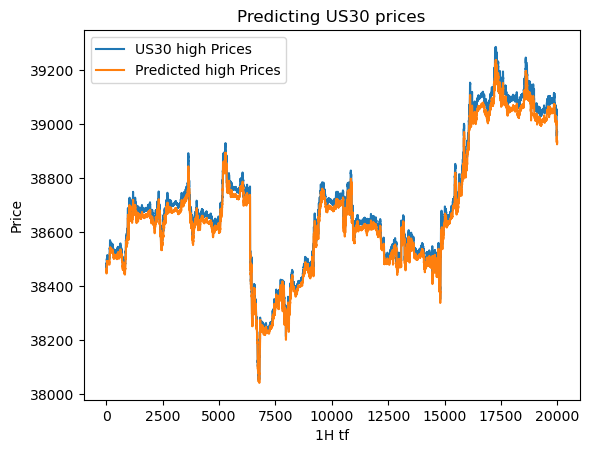

In [32]:
plt.plot(y_test[:,0], label='US30 high Prices')
plt.plot(prediction[:,0], label='Predicted high Prices')
plt.title('Predicting US30 prices')
plt.xlabel('1H tf')
plt.ylabel('Price')
plt.legend()               #plot of high prices or prediction and original
plt.show()

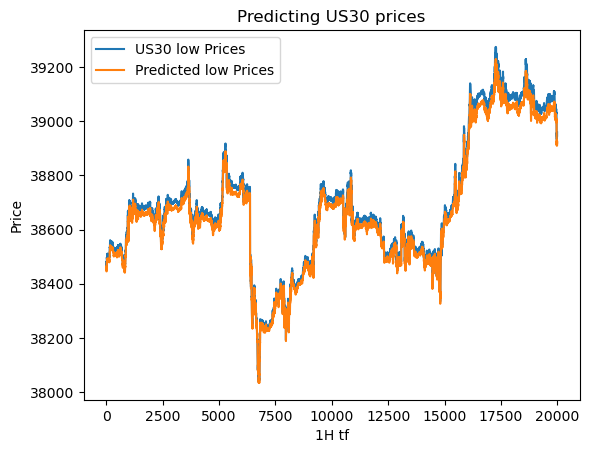

In [33]:
plt.plot(y_test[:,1], label='US30 low Prices')
plt.plot(prediction[:,1], label='Predicted low Prices')
plt.title('Predicting US30 prices')
plt.xlabel('1H tf')
plt.ylabel('Price')
plt.legend()
plt.show()              #I think you understood what this is. (Low prices)